# I] Import

In [1]:
import pandas, numpy, math, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

## functions & options


# II] Dataframe download

In [3]:
%%time
# DL liver samples IDs for normal and primary tumors
path = input_file_directory +'samples_IDs/Organ_specific_samples/'
directory = path + "samples_liver.tsv"
liver_samples_IDs= pandas.read_csv(directory, sep = "\t")
print(liver_samples_IDs.shape)

liver_samples_IDs = liver_samples_IDs.drop('samples', axis = 1)
liver_samples_IDs.head()

(479, 4)
Wall time: 4.96 ms


,sample,_sample_type,_primary_site
0,GTEX-1192X-1026-SM-5H12P,Normal Tissue,Liver
1,GTEX-11DXY-0526-SM-5EGGQ,Normal Tissue,Liver
2,GTEX-11DXZ-0126-SM-5EGGY,Normal Tissue,Liver
3,GTEX-11EQ9-0526-SM-5A5JZ,Normal Tissue,Liver
4,GTEX-11NUK-1226-SM-5P9GM,Normal Tissue,Liver


In [4]:
%%time
# DL all data ATG7 isoform expression
path = output_file_directory + "/ATG7/TCGA_GTEX/dataframes_for_input/df_ATG7_NormPrim.csv"
df_ATG7_NormPrim= pandas.read_csv(path, sep = ",")

#remove Survival information
df_ATG7_NormPrim.drop(df_ATG7_NormPrim.columns[[3, 4]], axis = 1, inplace = True)

print(df_ATG7_NormPrim.shape)
df_ATG7_NormPrim.head(2)

(16614, 20)
Wall time: 79.8 ms


,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_total,ATG7_1tpm,ATG7_2tpm,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,GTEX-ZTTD-0326-SM-57WFW,Normal Tissue,Muscle,5.042,3.860,2.390,0.2642,32.944283,14.519306,5.240574,1.199970,5.085097,3.955992,2.641679,20.95985,69.271996,25.002916,5.725088,0.440723,0.159074
1,GTEX-PX3G-1626-SM-2S1PT,Normal Tissue,Muscle,4.252,2.322,1.956,1.1320,19.052710,4.999249,3.878848,2.190624,4.325725,2.584782,2.286540,11.06872,45.165557,35.043325,19.791118,0.262390,0.203585


In [5]:
#Do not have negative tpm
print("min:", df_ATG7_NormPrim['ATG7_1tpm'].min())
test = df_ATG7_NormPrim
df_ATG7_NormPrim['ATG7_1tpm'] = numpy.where(df_ATG7_NormPrim['ATG7_1tpm'] < 0, 0, df_ATG7_NormPrim['ATG7_1tpm'])
df_ATG7_NormPrim['ATG7_2tpm'] = numpy.where(df_ATG7_NormPrim['ATG7_2tpm'] < 0, 0, df_ATG7_NormPrim['ATG7_2tpm'])
print("min:", df_ATG7_NormPrim['ATG7_1tpm'].min())

min: -1.4951130035000156e-07
min: 0.0


In [6]:
#find number of normal tissue
nb_normal = len(liver_samples_IDs[liver_samples_IDs['_sample_type'] == 'Normal Tissue'])

#select normal and primary separatlydd
normal_liver_labels = liver_samples_IDs.iloc[:nb_normal ,0:1]
print('number of normal tissue:', len(normal_liver_labels))

primary_liver_labels = liver_samples_IDs.iloc[nb_normal: ,0:1]
print('number of primary tumors:', len(primary_liver_labels))
print('\n', normal_liver_labels.head())

number of normal tissue: 110
number of primary tumors: 369

                      sample
0  GTEX-1192X-1026-SM-5H12P
1  GTEX-11DXY-0526-SM-5EGGQ
2  GTEX-11DXZ-0126-SM-5EGGY
3  GTEX-11EQ9-0526-SM-5A5JZ
4  GTEX-11NUK-1226-SM-5P9GM


In [7]:
#create a df_ATG7_NormPrim only with liver
df_ATG7_NormPrim_liver = liver_samples_IDs.merge(df_ATG7_NormPrim)
print('size should be:',110+369)
df_ATG7_NormPrim_liver.shape

size should be: 479


(479, 22)

In [8]:
#subset, split normal and primary
df_ATG7_Normal_liver = normal_liver_labels.merge(df_ATG7_NormPrim)
df_ATG7_Primary_liver = primary_liver_labels.merge(df_ATG7_NormPrim)

print(df_ATG7_Normal_liver.shape)
print(df_ATG7_Primary_liver.shape)
print(df_ATG7_Primary_liver.iloc[:,0:5].head())

(110, 20)
(369, 20)
            sample    Sample_Type Primary_Site   ATG7  ATG7_1
0  TCGA-2V-A95S-01  Primary Tumor        Liver  2.778   2.526
1  TCGA-2Y-A9GS-01  Primary Tumor        Liver  4.198   2.919
2  TCGA-2Y-A9GT-01  Primary Tumor        Liver  2.539   1.541
3  TCGA-2Y-A9GU-01  Primary Tumor        Liver  2.712   1.556
4  TCGA-2Y-A9GV-01  Primary Tumor        Liver  3.048   1.637


# III] ATG7 expression

## A) Distribution


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


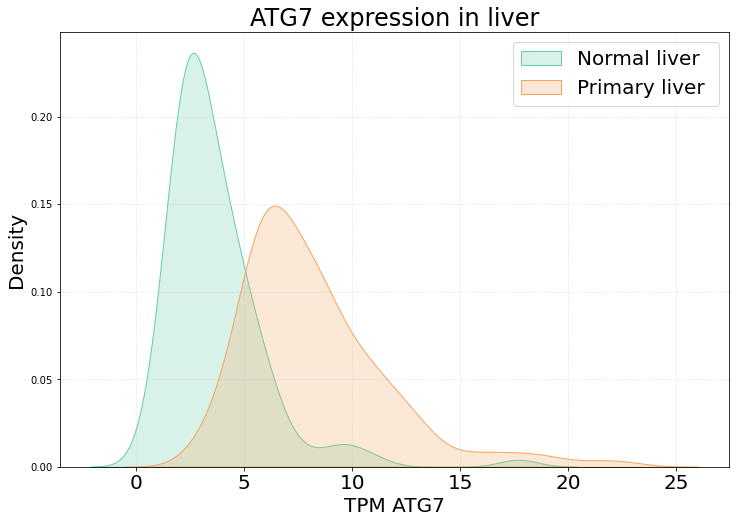

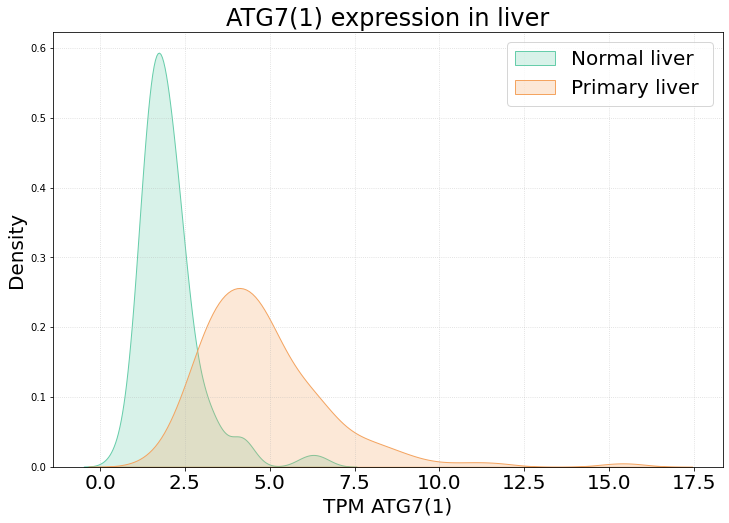

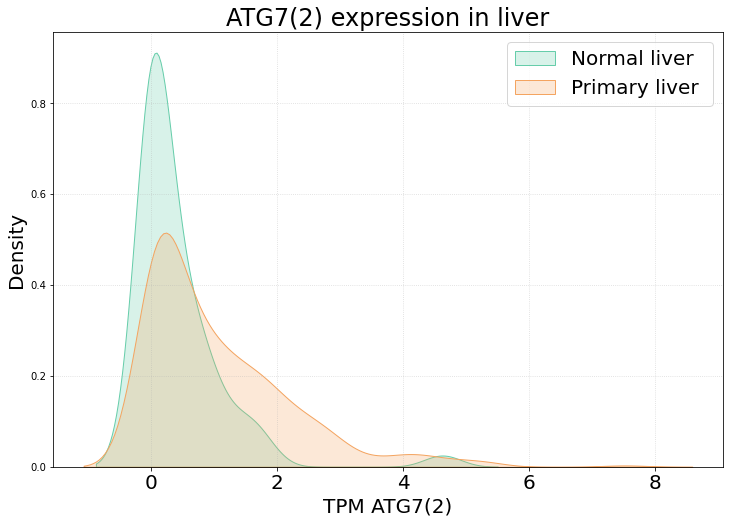

<Figure size 864x576 with 0 Axes>

In [9]:
# Distribution graph, for ATG7, iso1 & iso2
all_dfs = [[df_ATG7_Normal_liver, 'in liver', df_ATG7_Primary_liver, 'in primary liver']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], ['ATG7_2tpm', 'ATG7(2)']]


for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.grid(ls = ":", alpha=0.5)
    plt.xlabel('TPM '+ isoform[1])
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal liver","Primary liver "])
    
    #save
    title_file = 'distrib_liver' + isoform[1]
    path = 'ATG7/TCGA_GTEX/liver/figs_characterization/'
    plt.savefig(output_file_directory+path+title_file+'.svg')
    
    plt.show()
    plt.clf()

## B) Percentage do not express ATG7 isoforms

In [10]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal_liver, 'normal liver'], [df_ATG7_Primary_liver, 'primary liver']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)'], ['ATG7_3tpm', 'ATG7(3)']]

for df in all_dfs:
  print(df[1])
  for isoform in isoforms:
        
    QUOI = isoform[1]
    OU = df[1]
    all = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', QUOI)
  print()


normal liver
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
56.4 % of tumor do not express ATG7(2)
79.1 % of tumor do not express ATG7(3)

primary liver
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
20.3 % of tumor do not express ATG7(2)
48.8 % of tumor do not express ATG7(3)



In [11]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal_liver, 'normal liver'], [df_ATG7_Primary_liver, 'primary liver']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)']]

df_number_exp = []
what = []
sample_type = []
who_dontexp = []
perc_noexp = []
    
for df in all_dfs:
    for isoform in isoforms:
        #save what isoform
        what.append(isoform[1])
        #save sample_type
        sample_type.append(df[1])
        #have total sample number
        all_ = (df[0][isoform[0]]).shape
        #calculate number of sample who express the isoform
        without_exp = (df[0][isoform[0]]<0.1).sum()
        who_dontexp.append(without_exp)
        #convert result to percentage
        perc_without_exp = float((without_exp*100)/all_)   
        perc_noexp.append(round(perc_without_exp,1))

        #create a dictionnary and convert to dataframe
        d = dict(Isoforms = what, who_dontexp = who_dontexp, 
                 Percentage = perc_noexp, Sample_Type = sample_type)
        df_noexpr_distrib = pandas.DataFrame.from_dict(d, orient='index')
        df_noexpr_distrib = df_noexpr_distrib.T
          
df_noexpr_distrib

,Isoforms,who_dontexp,Percentage,Sample_Type
0,ATG7,0,0,normal liver
1,ATG7(1),0,0,normal liver
2,ATG7(2),62,56.4,normal liver
3,ATG7,0,0,primary liver
4,ATG7(1),0,0,primary liver
5,ATG7(2),75,20.3,primary liver


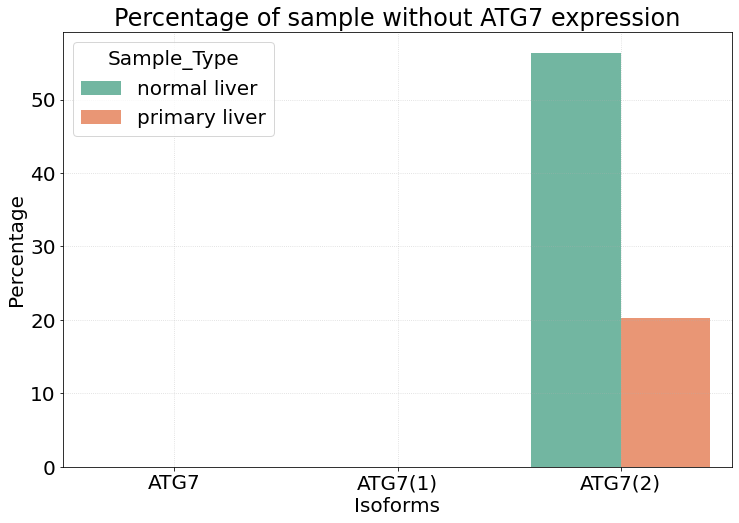

In [12]:
seaborn.barplot(data=df_noexpr_distrib, x="Isoforms", y="Percentage", hue="Sample_Type", 
                palette = 'Set2', orient = 'v')
plt.title("Percentage of sample without ATG7 expression")
plt.grid(ls = ":", alpha=0.5)
plt.yticks(fontsize=20)

path = 'ATG7/TCGA_GTEX/liver/figs_characterization/'
plt.savefig(output_file_directory+path+'percentage_expression_liver.svg')

## C) Expression figures

### 1) Value TPM

In [13]:
#control what numbers to select the good columns
df_ATG7_NormPrim_liver.iloc[:,9:12].head()

,ATG7_total,ATG7_1tpm,ATG7_2tpm
0,9.572192,6.501525,0.369874
1,2.219678,1.339991,0.000000
2,4.049219,1.690027,0.490070
3,4.431129,1.409982,1.669986
4,1.979960,1.750025,0.000000


479


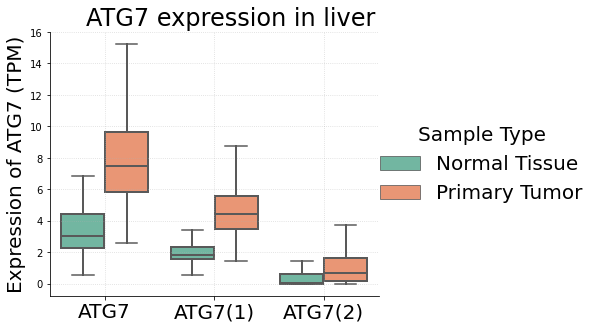

In [14]:
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim_liver
info = 'liver'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(9,12)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7'
data_distrib.loc[shape: shape*2,'x'] = 'ATG7(1)'
data_distrib.loc[shape*2:,'x'] = 'ATG7(2)'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.grid(ls = ":", alpha=0.5)
plt.ylabel('Expression of ATG7 (TPM)')
plt.xlabel('')
plt.title('ATG7 expression in '+ info, x=.55)

#save
plt.savefig(output_file_directory+path+'ATG7_exp_liver.svg')

In [15]:
#Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal_liver, 'all Normal liver',
            df_ATG7_Primary_liver, 'in primary liver']]

isoforms = ['ATG7_total', 'ATG7_1tpm', 'ATG7_2tpm']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


the pvalue between all Normal liver(3.010) and in primary liver(7.489) for ATG7_total is 1.132E-40
the pvalue between all Normal liver(1.850) and in primary liver(4.459) for ATG7_1tpm is 1.889E-46
the pvalue between all Normal liver(0.080) and in primary liver(0.710) for ATG7_2tpm is 6.641E-13



In [16]:
#median brut file to compare 
print(df_ATG7_Normal_liver['ATG7_total'].median())
print(df_ATG7_Normal_liver['ATG7_1tpm'].median())
print(df_ATG7_Normal_liver['ATG7_2tpm'].median())

3.009511574848644
1.8499736281866104
0.07999631033958332


### 2) Normalized

In [17]:
#control what numbers to select the good columns
df_ATG7_NormPrim_liver.iloc[:,20:22].head()

,ATG7_1norm,ATG7_2norm
0,0.679210,3.864044e-02
1,0.603687,-6.735721e-08
2,0.417371,1.210282e-01
3,0.318199,3.768760e-01
4,0.883869,-7.551227e-08


479


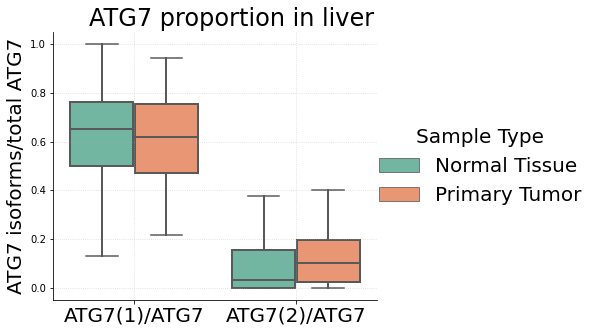

In [18]:
# Distribution: Data preparation + graph
data = [[df_ATG7_NormPrim_liver, 'liver']]

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(20,22)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7(1)/ATG7'
data_distrib.loc[shape:,'x'] = 'ATG7(2)/ATG7'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.grid(ls = ":", alpha=0.5)
plt.ylabel('ATG7 isoforms/total ATG7')
plt.xlabel('')
plt.title('ATG7 proportion in '+ info, x=0.55)

#save graph
plt.savefig(output_file_directory+path+'prop_liver.svg')

In [19]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal_liver, 'in normal liver', df_ATG7_Primary_liver, 'in primary liver']]

isoforms = ['ATG7_1norm', 'ATG7_2norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


NORMALIZED
the pvalue between in normal liver(0.651) and in primary liver(0.617) for ATG7_1norm is 1.432E-01
the pvalue between in normal liver(0.032) and in primary liver(0.099) for ATG7_2norm is 1.118E-06



## D) Correlation between the two isoforms

shape after removing extrem dots: (107, 20)
shape after removing extrem dots: (365, 20)
The correlation between iso1 and iso2 in Normal liver is: 0.13379372768357836 0.1694717185608989


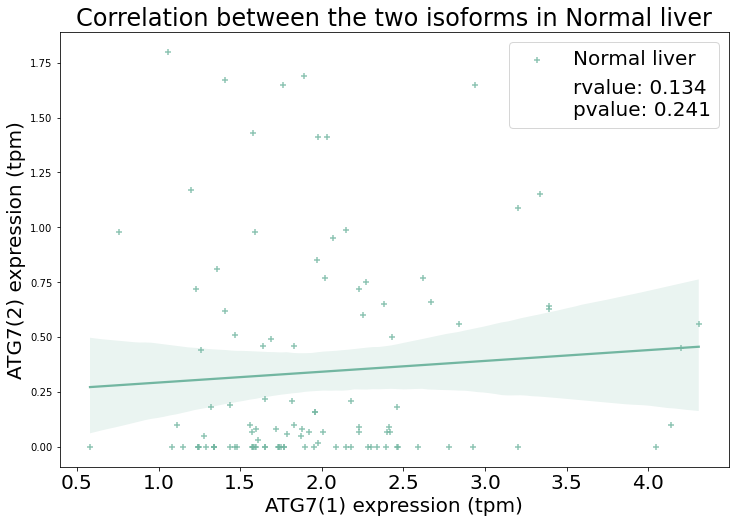


The correlation between iso1 and iso2 in Primary liver is: -0.2074785431346772 6.501752595300927e-05


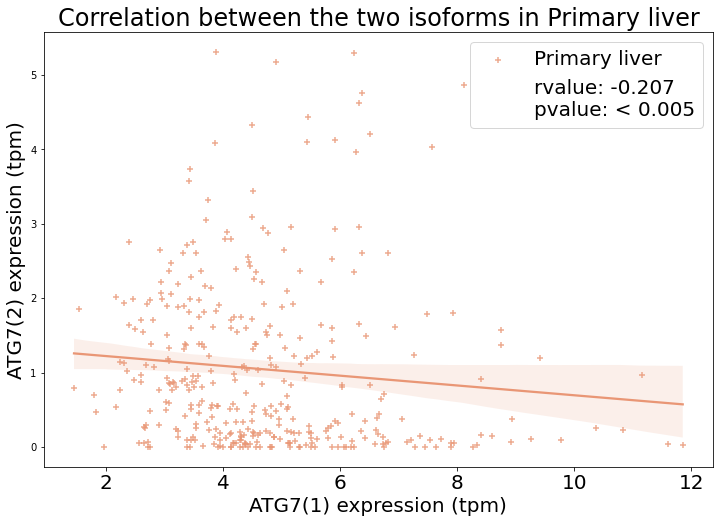

<Figure size 864x576 with 0 Axes>

In [20]:
#Remove the 0.5% extremities to have a nicer graph
tissues = [[df_ATG7_Normal_liver, "Normal tissue"], [df_ATG7_Primary_liver, "Primary tumor"]]

#Graph and stats_ spearman correlation
#graphdf_ATG7_Normal_liver
color1 = '#72B6A1'
color2 = '#e99675'

df_ATG7_Normal_liver2 = df_ATG7_Normal_liver[df_ATG7_Normal_liver['ATG7_1tpm'] < 4.5 ]
df_ATG7_Normal_liver2 = df_ATG7_Normal_liver2[df_ATG7_Normal_liver2['ATG7_2tpm'] < 2 ]
print("shape after removing extrem dots:",df_ATG7_Normal_liver2.shape)

df_ATG7_Primary_liver2 = df_ATG7_Primary_liver[df_ATG7_Primary_liver['ATG7_1tpm'] < 12 ]
df_ATG7_Primary_liver2 = df_ATG7_Primary_liver2[df_ATG7_Primary_liver2['ATG7_2tpm'] < 5.5 ]
print("shape after removing extrem dots:",df_ATG7_Primary_liver2.shape)

normal_tissues = [df_ATG7_Normal_liver2, "Normal liver", '0.241', color1]
primary_tissues = [df_ATG7_Primary_liver2, "Primary liver", "< 0.005", color2]
tissues = normal_tissues, primary_tissues

for tissue in tissues:
    x = tissue[0]['ATG7_1tpm'].to_list()
    y = tissue[0]['ATG7_2tpm'].to_list()    
    
    #stat Spearman correlation 
    r_value, p_value = scipy.stats.spearmanr(x, y)
    print("The correlation between iso1 and iso2 in",tissue[1],"is:", r_value, p_value)
    
    #graph
    seaborn.regplot(x=x,y=y, x_ci = 0, marker="+", label = tissue[1], color = tissue[3])
    seaborn.regplot(x=[],y=[], marker=" ", label= 'rvalue: '+str(round(r_value,3))+ "\npvalue: "+str(tissue[2]))

    name = "Correlation between the two isoforms in " + tissue[1]
    plt.title(name)
    plt.xlabel("ATG7(1) expression (tpm)")
    plt.ylabel('ATG7(2) expression (tpm)')

    plt.legend()

    #save
    title_file = 'liver_ATG7s_corr_' + tissue[1]
    plt.savefig(output_file_directory+path+title_file+'.svg')

    plt.show()  
    plt.clf()
    print()